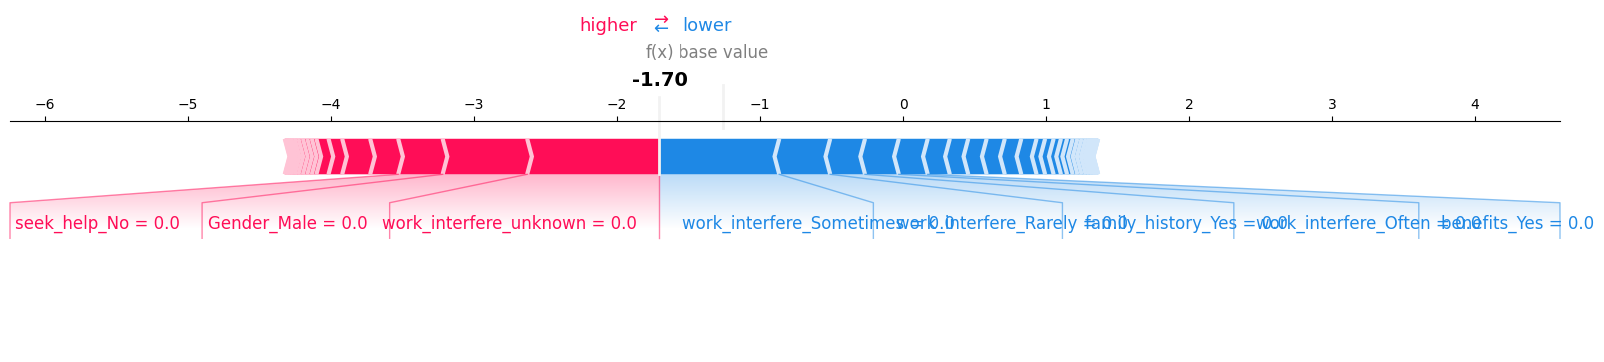

Prediction: No Treatment Needed
Probability: 0.15


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import shap
import joblib  # Import joblib

# Load and preprocess data (same as your original code)
df = pd.read_csv('survey.csv')
df = df.drop(['comments', 'Timestamp'], axis=1)
df["state"] = df["state"].fillna(df["Country"])
df['work_interfere'] = df['work_interfere'].fillna('unknown')
df = df.dropna(subset=['self_employed'])
df = df[(df['Age'] > 17) & (df['Age'] <= 100)]

# Gender Mapping
gender_mapping = {
    'Male': ['Male', 'male', 'M', 'm', 'Cis Male', 'cis male', 'Male (CIS)', 'cis-male/femme', 'Mail', 'Mailr', 'Malr', 'msle', 'guy (-ish) ^_^'],
    'Female': ['Female', 'female', 'F', 'f', 'Cis Female', 'cis-female/femme', 'Cis Woman', 'Female (cis)', 'Trans Female', 'Trans woman', 'Trans-female'],
    'Non-binary': ['Non-binary', 'non-binary', 'Genderqueer', 'genderqueer', 'Androgyne', 'Agender', 'fluid', 'Neuter', 'androgyne'],
    'Other': ['Other', 'Nah', 'All', 'Enby', 'something kinda male?', 'male leaning androgynous', 'queer', 'queer/she/they', 'queer/q/they', 'ostensibly male, unsure what that really means', 'Guy (-ish) ^_^', 'A little about you']
}

def map_gender(value):
    for key, values in gender_mapping.items():
        if value in values:
            return key
    return 'Other'

df['Gender'] = df['Gender'].apply(map_gender)
df['treatment'] = df['treatment'].replace({'Yes': 1, 'No': 0})

# Feature selection and preprocessing
X = df.drop('treatment', axis=1)
y = df['treatment']
X = pd.get_dummies(X, drop_first=True)

# Train-test split and scaling
# Train the model
lrc = LogisticRegression(solver='liblinear', penalty='l1')

# Save the model and training columns
# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train['Age'] = scaler.fit_transform(X_train[['Age']])
X_test['Age'] = scaler.transform(X_test[['Age']])
lrc.fit(X_train, y_train)

# Save the model, scaler, and training columns
joblib.dump(lrc, 'mental_health_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler
joblib.dump(X_train.columns, 'train_columns.pkl')

# SHAP explainer
explainer = shap.LinearExplainer(lrc, masker=shap.maskers.Independent(X_train))

def predict_mental_health(input_data):
    # Preprocess input data
    input_df = pd.DataFrame([input_data])
    input_df = pd.get_dummies(input_df, drop_first=True)
    input_df = input_df.reindex(columns=X_train.columns, fill_value=0)

    # Scale Age
    input_df['Age'] = scaler.transform(input_df[['Age']])

    # Predict
    prediction = lrc.predict(input_df)[0]
    prediction_proba = lrc.predict_proba(input_df)[0][1]

    # SHAP explanation
    shap_values = explainer.shap_values(input_df)
    shap.force_plot(explainer.expected_value, shap_values[0, :], input_df.iloc[0, :], matplotlib=True)

    return prediction, prediction_proba

if __name__ == "__main__":
    # Example input
    input_data = {
        'Age': 30,
        'Gender': 'Male',
        'Country': 'United States',
        'state': 'California',
        'self_employed': 'No',
        'family_history': 'Yes',
        'work_interfere': 'Sometimes',
        'no_employees': '6-25',
        'remote_work': 'Yes',
        'tech_company': 'Yes',
        'benefits': 'Yes',
        'care_options': 'Yes',
        'wellness_program': 'Yes',
        'seek_help': 'Yes',
        'anonymity': 'Yes',
        'leave': 'Somewhat easy',
        'mental_health_consequence': 'No',
        'phys_health_consequence': 'No',
        'coworkers': 'Yes',
        'supervisor': 'Yes',
        'mental_health_interview': 'Yes',
        'phys_health_interview': 'Yes',
        'mental_vs_physical': 'Yes',
        'obs_consequence': 'No'
    }

    # Predict and explain
    prediction, probability = predict_mental_health(input_data)
    print(f"Prediction: {'Needs Treatment' if prediction == 1 else 'No Treatment Needed'}")
    print(f"Probability: {probability:.2f}")